In [4]:
%matplotlib inline
from ast import literal_eval
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse as sp_sparse
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix,f1_score,classification_report
import re
import jieba as jb
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['font.sans-serif']="SimHei"
plt.rcParams['axes.unicode_minus']=False
plt.style.use('ggplot')

In [5]:
data1=pd.read_excel("C题全部数据/附件1.xlsx")
data2=pd.read_excel("C题全部数据/附件2.xlsx")
data3=pd.read_excel("C题全部数据/附件3.xlsx")
data4=pd.read_excel("C题全部数据/附件4.xlsx")

In [6]:
test=data2[["一级标签","留言详情"]]
#重命名列名
test.columns=["cat","review"]

test['cat_id'] = test['cat'].factorize()[0]
cat_id_df = test[['cat', 'cat_id']].drop_duplicates().sort_values('cat_id').reset_index(drop=True)
cat_to_id = dict(cat_id_df.values)
id_to_cat = dict(cat_id_df[['cat_id', 'cat']].values)
test.sample(10)

,cat,review,cat_id
1691,城乡建设,\n\t\t\t\t\t\n\t\t\t\t\t 蒋厅长，您好！ 我于2006年在D市...,0
417,城乡建设,\n\t\t\t\t\t\n\t\t\t\t\t经世龙城小区配套幼儿园办成公办园或委托办成普...,0
7725,商贸旅游,\n\t\t\t\t\t\n\t\t\t\t\t为什么我们L3县七座车年检费用要460，怎么...,5
1921,城乡建设,\n\t\t\t\t\t\n\t\t\t\t\t 我们是原I市公汽公司小区（I1区五一路）...,0
4140,教育文体,\n \n 尊敬的厅长： 我村为B7县八团乡东黄村，是革命老区。B7县第四...,3
174,城乡建设,\n\t\t\t\t\t\n\t\t\t\t\t尊敬的书记： 你好，我是一名星沙灰埠社区板...,0
7500,商贸旅游,\n\t\t\t\t\t\n\t\t\t\t\t 西地省J市J8县热水镇为4A级旅游区，可...,5
3056,交通运输,\n\t\t\t\t\t\n\t\t\t\t\t无网约车驾驶证，无网约车资格证，希望相关部门...,2
3941,教育文体,\n\n 您好！请问您：评小学高级教师十几年了，职称、定岗都一直在小学，学校是中小学都有的...,3
2891,环境保护,\n\t\t\t\t\t\n\t\t\t\t\t蛇山该养猪场地处I2区泥江口镇蛇山村正新公村...,1


In [7]:
#定义删除除字母,数字，汉字以外的所有符号的函数
def remove_punctuation(line):
    line = str(line)
    if line.strip()=='':
        return ''
    rule = re.compile(u"[^a-zA-Z0-9\u4E00-\u9FA5]")
    line = rule.sub('',line)
    return line
 
def stopwordslist(filepath):  
    stopwords = [line.strip() for line in open(filepath, 'r', encoding="GB18030").readlines()]  
    return stopwords  
 
#加载停用词
stopwords = stopwordslist("./stopword.txt")
#删除除字母,数字，汉字以外的所有符号
test['clean_review'] = test['review'].apply(remove_punctuation)
test.sample(10)

#分词，并过滤停用词
test['cut_review'] = test['clean_review'].apply(lambda x: " ".join([w for w in list(jb.cut(x)) if w not in stopwords]))
test.head()

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\ysj\AppData\Local\Temp\jieba.cache
Loading model cost 0.944 seconds.
Prefix dict has been built succesfully.


,cat,review,cat_id,clean_review,cut_review
0,城乡建设,\n\t\t\t\t\t\n\t\t\t\t\tA3区大道西行便道，未管所路口至加油站路段，...,0,A3区大道西行便道未管所路口至加油站路段人行道包括路灯杆被圈西湖建筑集团燕子山安置房项目施工...,A3 区 大道 西行 便道 未管 路口 加油站 路段 人行道 包括 路灯 杆 圈 西湖 建筑...
1,城乡建设,\n\t\t\t\t\t\n\t\t\t\t\t位于书院路主干道的在水一方大厦一楼至四楼人为...,0,位于书院路主干道的在水一方大厦一楼至四楼人为拆除水电等设施后烂尾多年用护栏围着不但占用人行道...,位于 书院 路 主干道 在水一方 大厦 一楼 四楼 人为 拆除 水电 设施 烂尾 多年 护栏...
2,城乡建设,\n\t\t\t\t\t\n\t\t\t\t\t尊敬的领导：A1区苑小区位于A1区火炬路，小...,0,尊敬的领导A1区苑小区位于A1区火炬路小区物业A市程明物业管理有限公司未经小区业主同意利用业...,尊敬 领导 A1 区苑 小区 位于 A1 区 火炬 路 小区 物业 市程明 物业管理 有限公...
3,城乡建设,\n\t\t\t\t\t\n\t\t\t\t\tA1区A2区华庭小区高层为二次供水，楼顶水箱...,0,A1区A2区华庭小区高层为二次供水楼顶水箱长年不洗现在自来水龙头的水严重霉味大家都知道水是我...,A1 区 A2 区华庭 小区 高层 二次 供水 楼顶 水箱 长年 不洗 自来水 龙头 水 霉...
4,城乡建设,\n\t\t\t\t\t\n\t\t\t\t\tA1区A2区华庭小区高层为二次供水，楼顶水箱...,0,A1区A2区华庭小区高层为二次供水楼顶水箱长年不洗现在自来水龙头的水严重霉味大家都知道水是我...,A1 区 A2 区华庭 小区 高层 二次 供水 楼顶 水箱 长年 不洗 自来水 龙头 水 霉...


In [8]:
tfidf = TfidfVectorizer(norm='l2', ngram_range=(1, 2))
features = tfidf.fit_transform(test.cut_review)
labels = test.cat_id
print(features.shape)
print('-----------------------------')
print(features)

(9210, 695514)
-----------------------------
  (0, 409709)	0.15622076750032005
  (0, 406948)	0.15622076750032005
  (0, 409766)	0.15622076750032005
  (0, 617318)	0.15622076750032005
  (0, 274459)	0.14104922086949562
  (0, 637788)	0.15622076750032005
  (0, 99530)	0.14950725116664162
  (0, 634622)	0.15622076750032005
  (0, 435693)	0.15622076750032005
  (0, 49251)	0.15622076750032005
  (0, 232893)	0.15622076750032005
  (0, 413457)	0.14950725116664162
  (0, 681671)	0.13547805873688806
  (0, 275701)	0.15622076750032005
  (0, 493309)	0.15622076750032005
  (0, 677215)	0.15622076750032005
  (0, 325818)	0.14104922086949562
  (0, 600985)	0.14474393552322437
  (0, 635211)	0.15622076750032005
  (0, 174801)	0.14950725116664162
  (0, 100026)	0.14950725116664162
  (0, 635059)	0.14950725116664162
  (0, 170998)	0.15622076750032005
  (0, 634815)	0.14950725116664162
  (0, 436628)	0.15622076750032005
  :	:
  (9209, 248734)	0.058550170015307164
  (9209, 522098)	0.06630952940277464
  (9209, 131196)	0.0617150

In [9]:
from sklearn.feature_selection import chi2
import numpy as np
 
N = 2
for cat, cat_id in sorted(cat_to_id.items()):
    features_chi2 = chi2(features, labels == cat_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(cat))
    print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:])))

# '交通运输':
  . Most correlated unigrams:
       . 快递
       . 出租车
  . Most correlated bigrams:
       . 的士 司机
       . 出租车 司机
# '劳动和社会保障':
  . Most correlated unigrams:
       . 退休
       . 社保
  . Most correlated bigrams:
       . 劳动 关系
       . 退休 人员
# '卫生计生':
  . Most correlated unigrams:
       . 医生
       . 医院
  . Most correlated bigrams:
       . 社会 抚养费
       . 乡村 医生
# '商贸旅游':
  . Most correlated unigrams:
       . 传销
       . 电梯
  . Most correlated bigrams:
       . 小区 电梯
       . 传销 组织
# '城乡建设':
  . Most correlated unigrams:
       . 小区
       . 业主
  . Most correlated bigrams:
       . 住房 公积金
       . 公积金 贷款
# '教育文体':
  . Most correlated unigrams:
       . 学生
       . 学校
  . Most correlated bigrams:
       . 教育局 领导
       . 培训 机构
# '环境保护':
  . Most correlated unigrams:
       . 环保局
       . 污染
  . Most correlated bigrams:
       . 周边 居民
       . 环保局 领导


In [10]:
#拆分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(test['cut_review'], test['cat_id'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
 
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)



from sklearn.model_selection import cross_val_score
 
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

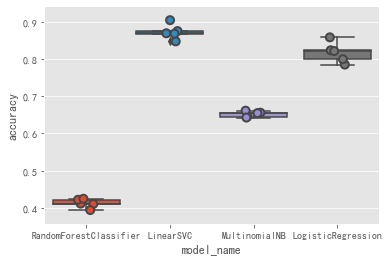

In [11]:
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [12]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.872856
LogisticRegression        0.817590
MultinomialNB             0.652009
RandomForestClassifier    0.412486
Name: accuracy, dtype: float64

{'C': 1.0, 'loss': 'hinge', 'penalty': 'l2', 'tol': 0.0001} 0.8953584235828818


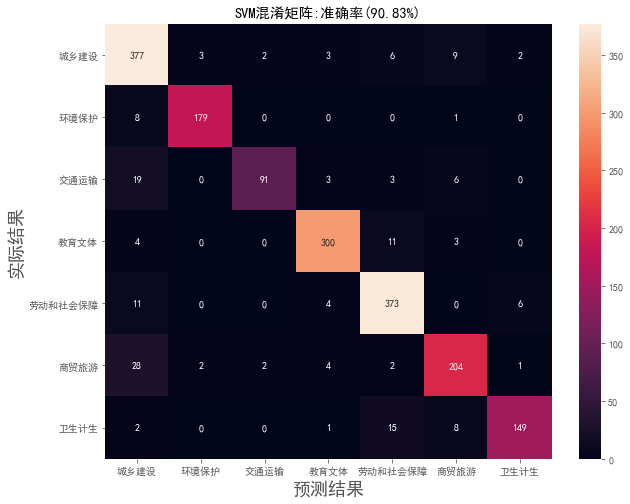

In [10]:
#训练模型
from sklearn.model_selection import GridSearchCV

param={
    "penalty":['l1','l2'],
    "loss":['hinge','squared_hinge'],
    "tol":[1e-4,1e-3,1e-2],
    "C":[0.3,0.5,1.0]
}
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels,
                                                                                 test.index,test_size=0.2, stratify=labels, random_state=0)


grid=GridSearchCV(model,param_grid=param,scoring='accuracy',cv=5)
grid.fit(X_train, y_train)
print(grid.best_params_,grid.best_score_)


best_model=grid.best_estimator_
best_model.fit(X_train, y_train)
y_pred =best_model.predict(X_test)
 
 
 
#生成混淆矩阵
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=cat_id_df.cat.values, yticklabels=cat_id_df.cat.values)
plt.ylabel('实际结果',fontsize=18)
plt.xlabel('预测结果',fontsize=18)
plt.title("SVM混淆矩阵:准确率({:.2f}%)".format(accuracy_score(y_test,y_pred)*100))
plt.show()

In [11]:
cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.84      0.94      0.89       402
           1       0.97      0.95      0.96       188
           2       0.96      0.75      0.84       122
           3       0.95      0.94      0.95       318
           4       0.91      0.95      0.93       394
           5       0.88      0.84      0.86       243
           6       0.94      0.85      0.89       175

    accuracy                           0.91      1842
   macro avg       0.92      0.89      0.90      1842
weighted avg       0.91      0.91      0.91      1842



In [12]:
F1=f1_score(y_test,y_pred,average='weighted')
print("F1为:",F1)

F1为: 0.9078154202868197
